In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

KeyboardInterrupt: 

In [4]:
import streamlit as st

In [3]:
!streamlit run car_bike_streamlit_app.py


^C


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = 'carbike-class\dataset\Car-Bike-Dataset'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

In [ ]:
data_dir = "carbike-class\dataset\Car-Bike-Dataset"
input_size= (128, 128) # Các ảnh sẽ được resize về một kích thước chung, độ phân giải càng cao càng tốn tài nguyên (CPU, GPU, RAM,..)
val_frac = 0.1         # Tỉ lệ của tập validation sẽ được chia ra từ tập train, thường chia theo các tỉ lệ 9:1, 8:2, 7:3
batch_size = 128       # Số ảnh xử lý/lần để cập nhật tham số, số càng cao càng tốn tài nguyên

# Tiền xử lý dữ liệu ảnh để mô hình học tốt hơn
data_augmentor = ImageDataGenerator(samplewise_center=True,            # Chuẩn hoá mean của các giá trị pixel
                                    samplewise_std_normalization=True, # Chuẩn hoá khoảng giá trị của các pixel
                                    validation_split=val_frac)

# Đọc dữ liệu từ thư mục và tiền xử lý
train_generator = data_augmentor.flow_from_directory(data_dir,
                                                     target_size=input_size,
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir,
                                                   target_size=input_size,
                                                   batch_size=batch_size,
                                                   subset="validation")

Found 3600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
train_generator.class_indices
len(train_generator.class_indices)

2

In [ ]:
num_classes = len(train_generator.class_indices) # 29
input_shape = (128, 128, 3)                      # 3 chiều cho ảnh RGB

# Cấu trúc mô hình tham khảo
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    # block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),     # Layer tích chập
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),     # Thêm Layer tích chập để học nhiều chi tiết hơn
    keras.layers.MaxPooling2D(pool_size=(2, 2)),                        # Layer MaxPool luôn theo sau layer Conv
    keras.layers.Dropout(0.5),                                          # Layer Dropout để mô hình không bị thiên kiến
    # block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),     # Cấu trúc giống với block 1, tăng chiều từ 32 lên 64
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    # block 3
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),    # Cấu trúc giống với block 1, tăng chiều từ 64 lên 128
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    # FCN block chịu trách nhiệm phân loại
    keras.layers.Flatten(),                                            # Chỉ có một layer flatten trong mô hình
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes),             # Layer Dense cuối có chiều là tổng số class
])
model.compile(optimizer='adam',                 # Luôn sử dụng `adam`
              loss='binary_crossentropy',  # `binary_crossentropy` cho lớp True/False, `categorical_crossentropy` cho nhiều lớp
              metrics=["accuracy"])             # Đánh giá mô hình dựa trên độ chính xác
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,790,626 (37.35 MB)

 Trainable params: 9,790,626 (37.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    # workers=4,
    # use_multiprocessing=True
)



Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 369s 13s/step - accuracy: 0.5023 - loss: 7.9637 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 367s 13s/step - accuracy: 0.5040 - loss: 7.9561 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 368s 13s/step - accuracy: 0.4970 - loss: 7.9693 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 367s 13s/step - accuracy: 0.5029 - loss: 7.9328 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 376s 13s/step - accuracy: 0.5092 - loss: 8.0083 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 373s 13s/step - accuracy: 0.5110 - loss: 7.9626 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 367s 13s/step - accuracy: 0.5022 - loss: 7.9776 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 367s 13s/step - accuracy: 0.5071 - loss: 7.9443 - val_accuracy: 0.

In [ ]:
model.save('carbike-class\model.keras')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
checkpoint = ModelCheckpoint(
    filepath='carbike-class\model.keras',  # Tên mẫu của file (v.d. checkpoint tại epoch 1 là `model_epoch_01.keras`)
    save_weights_only=False,                   # Lưu cả cấu trúc và thông số của mô hình
    save_best_only=False,                      # Set về True để chỉ lưu khi mô hình cải thiện
    monitor='val_accuracy',                        # Chọn thang đo để theo dõi mô hình (v.d. 'val_loss', 'val_accuracy')
    verbose=1                                  # Hiển thị thông tin ra màn hình khi mô hình được checkpoint
)

# Huấn luyện mô hình với config đã chọn
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,                            # Số lần train toàn bộ dữ liệu
    callbacks=[checkpoint]               # Thêm config checkpoint
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
 8/29 ━━━━━━━━━━━━━━━━━━━━ 5:43 16s/step - accuracy: 0.4909 - loss: 6.6563

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5040 - loss: 7.4412 
Epoch 1: saving model to /content/drive/MyDrive/model2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 534s 18s/step - accuracy: 0.5041 - loss: 7.4543 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 2/4
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4813 - loss: 7.9712 
Epoch 2: saving model to /content/drive/MyDrive/model2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 370s 13s/step - accuracy: 0.4818 - loss: 7.9712 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 3/4
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5027 - loss: 7.9703 
Epoch 3: saving model to /content/drive/MyDrive/model2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 370s 13s/step - accuracy: 0.5028 - loss: 7.9703 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 4/4
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5016 - loss: 7.9712 
Epoch 4: saving model to /content/drive/MyDrive/model2.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 388s 13s/step - accuracy: 0.5014 - loss: 7.9712 - va

In [ ]:
import numpy as np
from tensorflow.keras.saving import load_model

# Load model từ folder working
loaded_model = load_model('carbike-class\model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [ ]:
test_images = glob('carbike-class\dataset\Bike and Car\Test\Car\Cars-on-Street-Through-Chinatown.jpg')
test_images[:1]

['/content/drive/MyDrive/Bike and Car/Test/Car/Cars-on-Street-Through-Chinatown.jpg']

In [ ]:
classes = train_generator.class_indices
classes = dict((v,k) for k,v in classes.items())
classes

{0: 'Bike', 1: 'Car'}

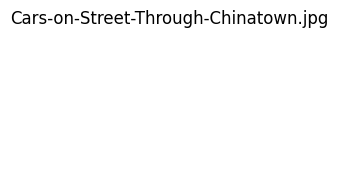

In [ ]:
if len(test_images) > 1:
    test_image_path = test_images[1]
else:
    test_image_path = test_images[0]

im = cv2.imread(test_image_path)
plt.rcParams['figure.figsize'] = (2.0, 2.0)

plt.title(test_image_path.split("/")[-1])
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
classes = train_generator.class_indices


classes = {v: k for k, v in classes.items()}

# Load and preprocess the image
img = image.load_img(test_image_path, target_size=(128, 128))  # Resize to (128, 128)
img_array = image.img_to_array(img)  # Convert from image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension: batch_size=1

# Create data generator with preprocessing
test_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)
img_generator = test_datagen.flow(img_array, batch_size=1)  # Use `flow`

# Make prediction
prediction = loaded_model.predict(next(img_generator))  # Predict using the model
prediction_label = np.argmax(prediction)  # Get the predicted label

# Check if the predicted label exists in `classes`
if prediction_label in classes:
    print("Prediction:", prediction_label)  # Print the class name
else:
    print("Prediction label not found in classes. Please check your model's output.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Prediction: 1


In [ ]:
test_dir = "carbike-class\dataset\Bike and Car\Test"   # Vì ảnh trong test không chia theo class nên lấy đường dẫn đến thư mục mẹ
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=input_size,
                                                  batch_size=1,
                                                  shuffle=None,
                                                  class_mode=None)

Found 380 images belonging to 2 classes.


In [ ]:
preds = loaded_model.predict(test_generator, verbose=1)
preds = np.argmax(preds, axis=1)
preds_labels = [classes[pred] for pred in preds]
print(preds_labels)

380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step
['Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Bike', 'Bike', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Bike', 'Car', 'Car', 'Car', 'Car', 'Bike', 'Car', 'Car', 'Car', 'Bike', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Bike', 'Car', 'Bike', 'Car', 'Car', 'Bike', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Bike', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Bike', 'Car', 'Bike', 'Bike', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car', 'Car',

In [ ]:
val_loss, val_acc = loaded_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.4639 - loss: 2.9585
Validation Accuracy: 46.25%
